Notebook – Adım 1: Ortam & Veri Yükleme

CSV mevcut mu?  True
Image klasörü mevcut mu?  True
CSV boyutu: (7095, 3)
📊 Sınıf dağılımı:
ClassId
1     897
2     247
3    5150
4     801
Name: count, dtype: int64

🔎 Yüzdelik dağılım:
ClassId
1    12.642706
2     3.481325
3    72.586328
4    11.289641
Name: count, dtype: float64


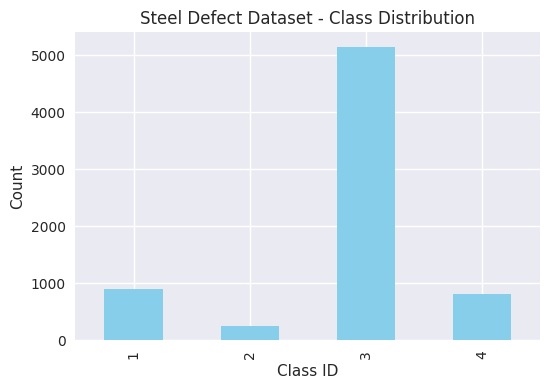

In [1]:
# Adım 1: Temel kütüphaneler
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Notebook içinde görsellik
plt.style.use("seaborn-v0_8")

# Adım 2: Dosya yollarını tanımla
train_csv_path = "/app/data/raw/train.csv"
train_images_dir = "/app/data/raw/train_images"

# Kontrol
print("CSV mevcut mu? ", os.path.exists(train_csv_path))
print("Image klasörü mevcut mu? ", os.path.exists(train_images_dir))


# Adım 3: CSV yükleme
train_df = pd.read_csv(train_csv_path)
print("CSV boyutu:", train_df.shape)
train_df.head()
df = pd.read_csv(train_csv_path)

# Class dağılımı
class_counts = df["ClassId"].value_counts().sort_index()

print("📊 Sınıf dağılımı:")
print(class_counts)

# Normalize edip yüzdelik gösterelim
print("\n🔎 Yüzdelik dağılım:")
print(class_counts / class_counts.sum() * 100)

# Çizdir
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color="skyblue")
plt.title("Steel Defect Dataset - Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

Notebook – Adım 2: Veri Keşfi (EDA)

In [2]:
# Genel bilgi
print(train_df.info())

# Kaç farklı sınıf var?
print("Sınıflar:", train_df['ClassId'].unique())

# Sınıf dağılımı
print("Sınıf dağılımı:\n", train_df['ClassId'].value_counts())

# Hatasız görüntü (EncodedPixels = NaN)
num_no_defect = train_df['EncodedPixels'].isnull().sum()
print(f"\nKusursuz satır sayısı: {num_no_defect}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB
None
Sınıflar: [1 3 4 2]
Sınıf dağılımı:
 ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

Kusursuz satır sayısı: 0


In [3]:
# Görsellerin varlığını kontrol et
all_image_paths = glob(os.path.join(train_images_dir, "*.jpg"))
print(f"Toplam {len(all_image_paths)} görüntü bulundu.")

# Dosya adlarıyla df oluştur
all_image_ids = [os.path.basename(p) for p in all_image_paths]
all_images_df = pd.DataFrame(all_image_ids, columns=["ImageId"])

# train.csv ile birleştir
full_df = all_images_df.merge(train_df, on="ImageId", how="left")

print("Birleşik df boyutu:", full_df.shape)
full_df.head()


Toplam 12568 görüntü bulundu.
Birleşik df boyutu: (12997, 3)


,ImageId,ClassId,EncodedPixels
0,5facf38ab.jpg,NaN,NaN
1,4e9055d9e.jpg,1.0,124667 3 124918 8 125081 14 125169 13 125319 4...
2,c0eb3a086.jpg,2.0,117641 30 117897 90 118153 120 118409 120 1186...
3,578e97b72.jpg,NaN,NaN
4,3a14b011a.jpg,3.0,87130 28 87342 86 87573 125 87828 140 88083 15...


Notebook – Adım 3: RLE → Maske Fonksiyonu

In [4]:
import sys
sys.path.append("/app/src")  # projenin src klasörünü ekle
from data.rle_decoder import rle_to_mask, build_multilabel_mask


Tek RLE Testi

Empty mask sum: 0


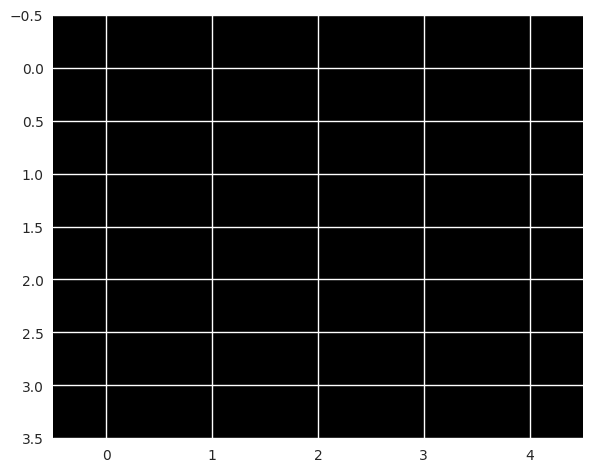

Mask sum: 3


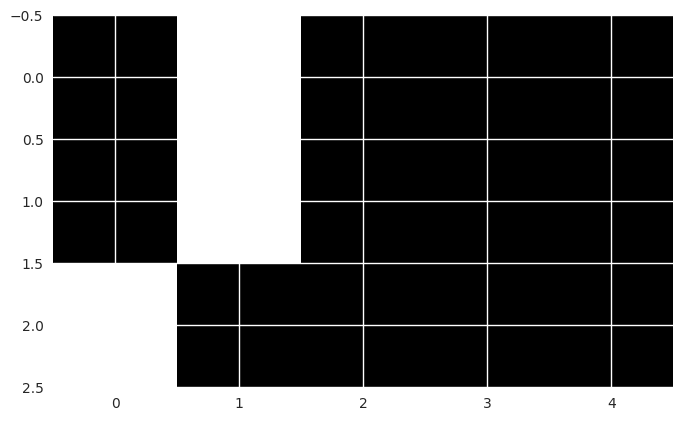

In [5]:
# 1. NaN örneği
mask_empty = rle_to_mask(None, (4, 5))
print("Empty mask sum:", mask_empty.sum())  # 0 olmalı
plt.imshow(mask_empty, cmap="gray"); plt.show()

# 2. Basit bir RLE string
mask_test = rle_to_mask("3 3", (3, 5))
print("Mask sum:", mask_test.sum())  # 3 olmalı
plt.imshow(mask_test, cmap="gray"); plt.show()


Çok-kanallı Maske Testi

Mask shape: (4, 256, 1600)
Class pixel sums: [0 0 0 0]


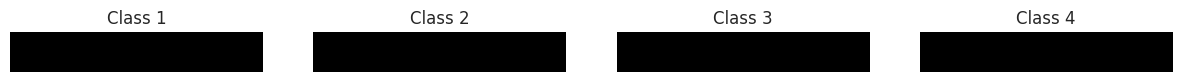

In [6]:
# Örnek bir görüntü al
image_id = full_df["ImageId"].iloc[0]
rows = full_df[full_df["ImageId"] == image_id]

multi_mask = build_multilabel_mask(rows, shape=(256,1600), num_classes=4)
print("Mask shape:", multi_mask.shape)   # (4, H, W)
print("Class pixel sums:", multi_mask.sum(axis=(1,2)))

# Her sınıfı ayrı görselleştir
fig, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
    axs[i].imshow(multi_mask[i], cmap="gray")
    axs[i].set_title(f"Class {i+1}")
    axs[i].axis("off")
plt.show()


Çok-kanallı Maske Testi (Notebook hücresi)

Kusurlu görüntü: 4e9055d9e.jpg


,ImageId,ClassId,EncodedPixels
1,4e9055d9e.jpg,1.0,124667 3 124918 8 125081 14 125169 13 125319 4...


Mask shape: (4, 256, 1600)
Class pixel sums: [4331    0    0    0]


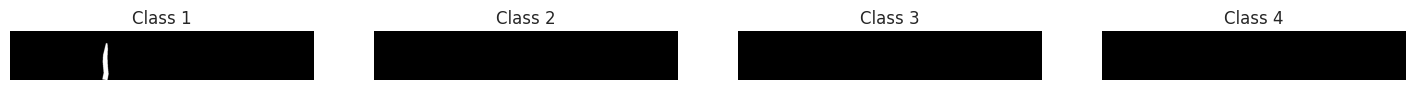

In [7]:
# Kusurlu bir görüntü seçelim
defect_id = full_df[full_df["EncodedPixels"].notna()]["ImageId"].iloc[0]
rows_defect = full_df[full_df["ImageId"] == defect_id]

print("Kusurlu görüntü:", defect_id)
display(rows_defect)

multi_mask_def = build_multilabel_mask(rows_defect, shape=(256,1600), num_classes=4)
print("Mask shape:", multi_mask_def.shape)
print("Class pixel sums:", multi_mask_def.sum(axis=(1,2)))

# Görselleştirme
fig, axs = plt.subplots(1, 4, figsize=(18, 5))
for i in range(4):
    axs[i].imshow(multi_mask_def[i], cmap="gray")
    axs[i].set_title(f"Class {i+1}")
    axs[i].axis("off")
plt.show()


Overlay Fonksiyonu

In [8]:
import cv2

def overlay_mask_on_image(image_path: str, mask: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    """
    Görüntü üzerine 4-kanallı maskeyi renklendirip bindirir.
    
    Args:
        image_path (str): Orijinal görüntünün yolu.
        mask (np.ndarray): (4, H, W) çok-kanallı maske.
        alpha (float): Maske karışım oranı [0-1].
    
    Returns:
        np.ndarray: RGB formatında overlay görüntü.
    """
    # Görüntüyü yükle
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape
    assert mask.shape[1:] == (h, w), f"Mask shape {mask.shape} image shape {(h, w)} ile uyuşmuyor!"

    # Maske kanallarını HWC’ye çevir
    mask_hwc = np.transpose(mask, (1, 2, 0))  # (H, W, 4)

    # Renk paleti (her sınıf için ayrı renk)
    color_map = np.array([
        [255,   0,   0],   # Class 1 → Kırmızı
        [  0, 255,   0],   # Class 2 → Yeşil
        [  0,   0, 255],   # Class 3 → Mavi
        [255, 255,   0],   # Class 4 → Sarı
    ], dtype=np.uint8)

    # Renkli maske üret
    color_mask = (mask_hwc @ color_map).clip(0, 255).astype(np.uint8)  # (H, W, 3)

    # Overlay
    overlay = cv2.addWeighted(img, 1.0, color_mask, alpha, 0)
    return overlay


🔹 Overlay Testi

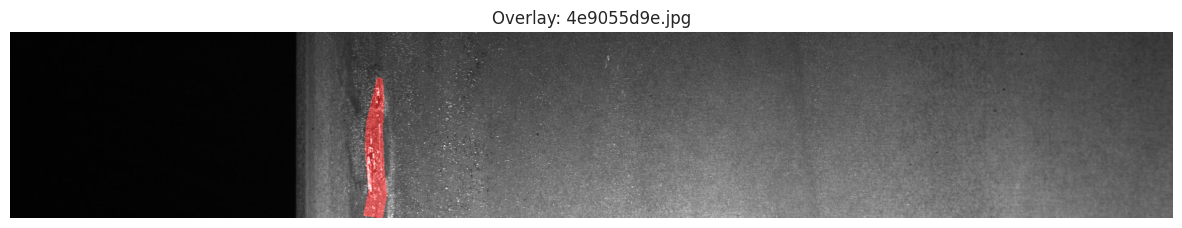

In [9]:
# Kusurlu bir örnek seçelim
defect_id = full_df[full_df["EncodedPixels"].notna()]["ImageId"].iloc[0]
rows_defect = full_df[full_df["ImageId"] == defect_id]
multi_mask_def = build_multilabel_mask(rows_defect, shape=(256,1600), num_classes=4)

# Orijinal yol
img_path = os.path.join(train_images_dir, defect_id)

# Overlay uygula
overlay_img = overlay_mask_on_image(img_path, multi_mask_def, alpha=0.5)

# Görselleştir
plt.figure(figsize=(15,7))
plt.imshow(overlay_img)
plt.title(f"Overlay: {defect_id}")
plt.axis("off")
plt.show()


Dataset Testi

In [10]:
from torch.utils.data import DataLoader
import sys
sys.path.append("/app/src")  # projenin src yolunu ekle (senin docker path'ine göre)

from data.dataset import SteelDefectDataset, build_full_dataframe

# Full df oluştur
full_df = build_full_dataframe(train_df, train_images_dir)

# Dataset örneği
ds = SteelDefectDataset(full_df, train_images_dir, shape=(256,1600), num_classes=4, load_rgb=True)

print("Dataset length:", len(ds))

# İlk örnek
img, mask, meta = ds[0]
print("Image tensor:", img.shape, img.dtype)   # (3, H, W), float32
print("Mask tensor:", mask.shape, mask.dtype) # (4, H, W), float32
print("Meta:", meta)

# Küçük DataLoader
loader = DataLoader(ds, batch_size=2, shuffle=True)
batch = next(iter(loader))
print("Batch image shape:", batch[0].shape)
print("Batch mask shape:", batch[1].shape)


Dataset length: 12568
Image tensor: torch.Size([3, 256, 1600]) torch.float32
Mask tensor: torch.Size([4, 256, 1600]) torch.float32
Meta: {'image_id': '0002cc93b.jpg'}
Batch image shape: torch.Size([2, 3, 256, 1600])
Batch mask shape: torch.Size([2, 4, 256, 1600])


Image shape: torch.Size([3, 256, 1600]) torch.float32
Mask shape: torch.Size([4, 256, 1600]) torch.float32


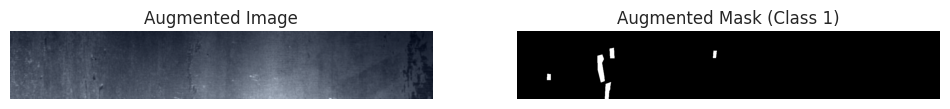

In [11]:
from src.data.dataset import SteelDefectDataset, build_full_dataframe
from src.data.transforms import get_train_transforms, get_valid_transforms

# Dataset + transform test
full_df = build_full_dataframe(train_df, train_images_dir)

# Eğitim dataset'i (augmentli)
train_ds = SteelDefectDataset(full_df, train_images_dir, transforms=get_train_transforms())

# Validation dataset'i (sadece resize + normalize)
valid_ds = SteelDefectDataset(full_df, train_images_dir, transforms=get_valid_transforms())

# Bir örnek çekelim
img, mask, meta = train_ds[0]

print("Image shape:", img.shape, img.dtype)   # torch.Size([3, H, W])
print("Mask shape:", mask.shape, mask.dtype) # torch.Size([4, H, W])

# Görselleştirme
import matplotlib.pyplot as plt

# Torch -> numpy
img_np = img.permute(1,2,0).cpu().numpy()
mask_np = mask.permute(1,2,0).cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow((img_np - img_np.min()) / (img_np.max() - img_np.min()))  # normalize görsellik için
axs[0].set_title("Augmented Image")
axs[0].axis("off")

axs[1].imshow(mask_np[...,0], cmap="gray")  # sadece Class 1
axs[1].set_title("Augmented Mask (Class 1)")
axs[1].axis("off")
plt.show()


Seçilen kusurlu görüntü: afbab41f0.jpg
Image shape: torch.Size([3, 256, 1600])
Mask shape: torch.Size([4, 256, 1600])


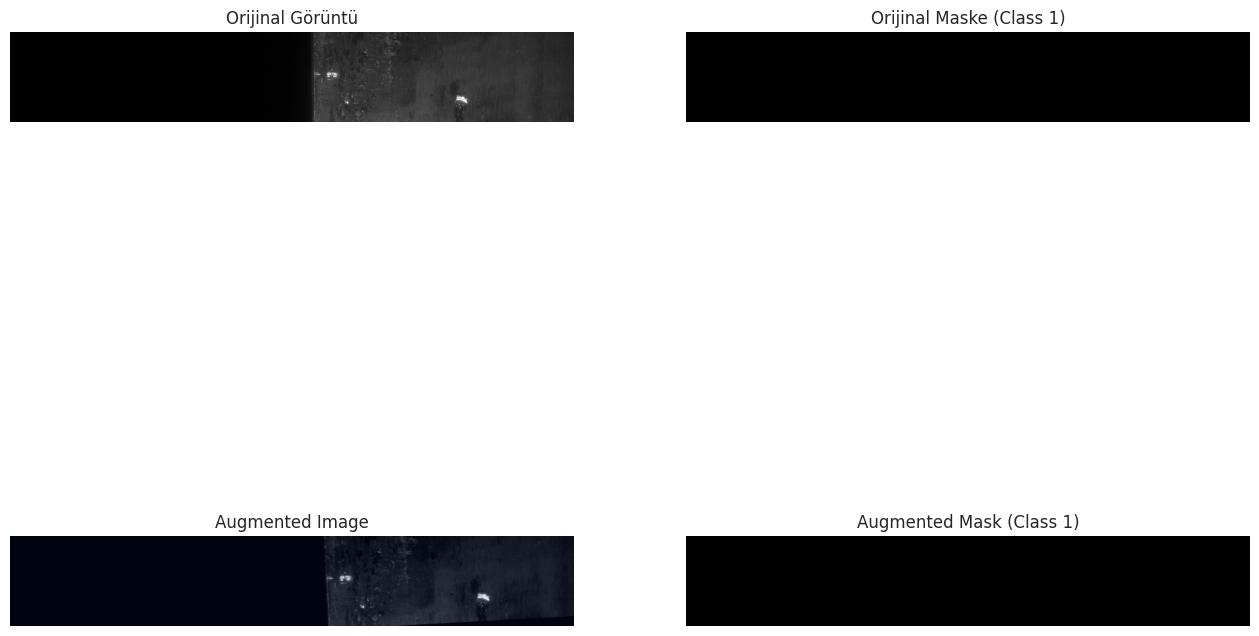

In [12]:
import random
from src.data.dataset import SteelDefectDataset, build_full_dataframe
from src.data.transforms import get_train_transforms
import matplotlib.pyplot as plt

# Full DataFrame oluştur
full_df = build_full_dataframe(train_df, train_images_dir)

# Kusurlu görüntülerden birini seçelim
defect_ids = full_df[full_df["EncodedPixels"].notna()]["ImageId"].unique()
sample_id = random.choice(defect_ids)
rows = full_df[full_df["ImageId"] == sample_id]

print("Seçilen kusurlu görüntü:", sample_id)

# Dataset örneği (sadece bu görüntü ile test etmek için küçük bir df)
sample_df = rows.copy()
sample_dataset = SteelDefectDataset(sample_df, train_images_dir, transforms=get_train_transforms())

# Augmentasyon sonucu görüntü ve maske al
img, mask, meta = sample_dataset[0]

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

# Torch -> numpy
img_np = img.permute(1, 2, 0).cpu().numpy()
mask_np = mask.permute(1, 2, 0).cpu().numpy()

# Görselleştirme: orijinal + augmentli
from src.data.rle_decoder import build_multilabel_mask
import cv2, os

# Orijinal görüntü
orig_path = os.path.join(train_images_dir, sample_id)
orig_img = cv2.cvtColor(cv2.imread(orig_path), cv2.COLOR_BGR2RGB)
orig_mask = build_multilabel_mask(rows, shape=(256,1600))

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

axs[0,0].imshow(orig_img)
axs[0,0].set_title("Orijinal Görüntü")
axs[0,0].axis("off")

axs[0,1].imshow(orig_mask[0], cmap="gray")
axs[0,1].set_title("Orijinal Maske (Class 1)")
axs[0,1].axis("off")

axs[1,0].imshow((img_np - img_np.min()) / (img_np.max() - img_np.min()))
axs[1,0].set_title("Augmented Image")
axs[1,0].axis("off")

axs[1,1].imshow(mask_np[...,0], cmap="gray")
axs[1,1].set_title("Augmented Mask (Class 1)")
axs[1,1].axis("off")

plt.show()


– DataLoader Testi

Batch image shape: torch.Size([2, 3, 256, 1600])
Batch mask shape: torch.Size([2, 4, 256, 1600])
Meta örnek: {'image_id': 'e52f2f2de.jpg'}

Image 0 (e52f2f2de.jpg) - Class pixel sums: [10852.     0.     0.     0.]


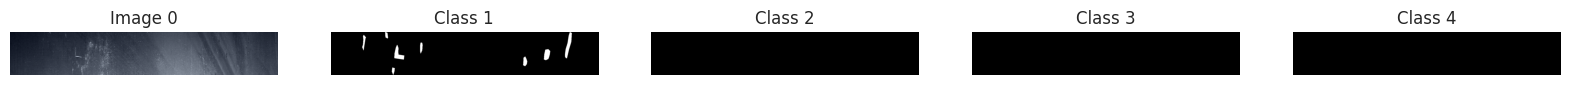


Image 1 (0d9d2aa59.jpg) - Class pixel sums: [   0.    0. 4815.    0.]


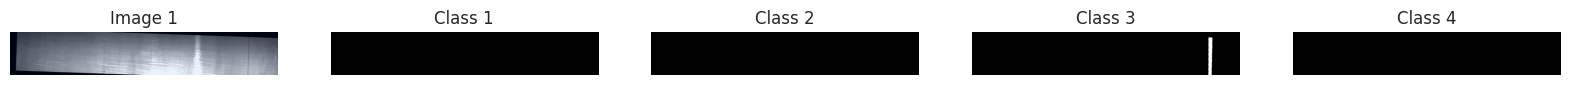

In [13]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Custom collate_fn (metas = list of dict)
def collate_fn(batch):
    images, masks, metas = zip(*batch)
    return torch.stack(images), torch.stack(masks), list(metas)

# DataLoader
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,   # Notebook için güvenli
    collate_fn=collate_fn
)

# İlk batch
images, masks, metas = next(iter(train_loader))

print("Batch image shape:", images.shape)   # (B, 3, H, W)
print("Batch mask shape:", masks.shape)    # (B, 4, H, W)
print("Meta örnek:", metas[0])             # {'image_id': 'xxx.jpg'}

# Görselleştirme
for i in range(images.shape[0]):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mask = masks[i].cpu().numpy()  # (4, H, W)

    print(f"\nImage {i} ({metas[i]['image_id']}) - Class pixel sums:", mask.sum(axis=(1,2)))

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].imshow((img - img.min()) / (img.max() - img.min()))
    axs[0].set_title(f"Image {i}")
    axs[0].axis("off")

    # Her class için ayrı plot
    for c in range(4):
        axs[c+1].imshow(mask[c], cmap="gray")
        axs[c+1].set_title(f"Class {c+1}")
        axs[c+1].axis("off")

    plt.show()


In [14]:
import torch
from torch.utils.data import DataLoader

# ✅ Model kodunu buraya ekliyoruz
import torch.nn as nn
import torchvision.models as models

class UNetResNet18(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super().__init__()
        base_model = models.resnet18(weights="IMAGENET1K_V1" if pretrained else None)

        # Encoder
        self.enc1 = nn.Sequential(base_model.conv1, base_model.bn1, base_model.relu)  # (64, H/2, W/2)
        self.enc2 = nn.Sequential(base_model.maxpool, base_model.layer1)              # (64, H/4, W/4)
        self.enc3 = base_model.layer2                                                # (128, H/8, W/8)
        self.enc4 = base_model.layer3                                                # (256, H/16, W/16)
        self.enc5 = base_model.layer4                                                # (512, H/32, W/32)

        # Decoder
        self.up4 = self._up_block(512, 256)
        self.up3 = self._up_block(256, 128)
        self.up2 = self._up_block(128, 64)
        self.up1 = self._up_block(64, 64)

        # Son katman
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

        # Ek upsample → output'u input boyutuna eşitle
        self.upsample_out = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

    def _up_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)

        # Decoder + skip connections
        d4 = self.up4(e5) + e4
        d3 = self.up3(d4) + e3
        d2 = self.up2(d3) + e2
        d1 = self.up1(d2) + e1

        out = self.final(d1)          # (B, C, 128, 800)
        out = self.upsample_out(out)  # (B, C, 256, 1600)
        return out


# ✅ Model instance oluştur
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetResNet18(num_classes=4, pretrained=False).to(device)

# ✅ DataLoader'dan bir batch al
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
images, masks, metas = next(iter(train_loader))
images, masks = images.to(device), masks.to(device)

# ✅ Forward pass
with torch.no_grad():
    outputs = model(images)

print("Input shape :", images.shape)   # (B, 3, 256, 1600)
print("Output shape:", outputs.shape)  # (B, 4, 256, 1600)


Input shape : torch.Size([2, 3, 256, 1600])
Output shape: torch.Size([2, 4, 256, 1600])


In [15]:
import torch
from models.unet import UNetResNet18

# Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetResNet18(num_classes=4, pretrained=False).to(device)

# DataLoader'dan bir batch al
images, masks, metas = next(iter(train_loader))
images = images.to(device)

# Forward pass
with torch.no_grad():
    outputs = model(images)

print("Input shape :", images.shape)   # (B, 3, 256, 1600)
print("Output shape:", outputs.shape)  # (B, 4, 256, 1600)
print("Meta örnek :", metas[0])


Input shape : torch.Size([2, 3, 256, 1600])
Output shape: torch.Size([2, 4, 256, 1600])
Meta örnek : {'image_id': '09e06e897.jpg'}


In [16]:
import torch
from losses.dice_loss import DiceLoss
from losses.focal_loss import FocalLoss

# Dummy veri
preds = torch.randn(2, 4, 256, 1600)  # logits
targets = torch.randint(0, 2, (2, 4, 256, 1600)).float()

dice_loss = DiceLoss()
focal_loss = FocalLoss()

print("Dice Loss :", dice_loss(preds, targets).item())
print("Focal Loss:", focal_loss(preds, targets).item())


Dice Loss : 0.4998384714126587
Focal Loss: 0.08658777922391891


In [20]:
import torch
from torch.utils.data import DataLoader, Subset

from models.unet import UNetResNet18
from losses.dice_loss import DiceLoss
from engines.training_engine import train_one_epoch, validate_one_epoch

# Küçük subset (örnek olarak ilk 8 görüntü)
train_subset = Subset(train_ds, range(8))
val_subset   = Subset(train_ds, range(8))

train_stats = train_one_epoch(model, train_loader, optimizer, device=device)
val_stats   = validate_one_epoch(model, val_loader, device=device)

# Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetResNet18(num_classes=4, pretrained=False).to(device)

# Loss & Optimizer
loss_fn = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 1 epoch train + validate
train_stats = train_one_epoch(model, train_loader, optimizer, device=device)
val_stats   = validate_one_epoch(model, val_loader, device=device)

print("Train stats:", train_stats)
print("Val stats  :", val_stats)


Train stats: {'loss': 0.31029006093740463, 'dice': 0.19661960005760193, 'per_class_dice': [0.0009381273994222283, 1.0056316890327821e-10, 0.5, 0.03835322707891464]}
Val stats  : {'loss': 0.31607232987880707, 'dice': 0.22768383473157883, 'per_class_dice': [0.0003675391199067235, 2.821073374903449e-09, 0.5, 0.038269851356744766]}


In [21]:
import torch

def dice_coefficient(preds: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5, eps: float = 1e-8) -> torch.Tensor:
    """
    Dice Coefficient (F1 Score) for segmentation.
    
    Args:
        preds: (B, C, H, W) logits
        targets: (B, C, H, W) binary masks {0,1}
        threshold: probability threshold to binarize predictions
        eps: numerical stability constant
    """
    # Sigmoid → [0,1]
    preds = torch.sigmoid(preds)

    # Binarize
    preds = (preds > threshold).float()

    preds = preds.contiguous().view(preds.size(0), preds.size(1), -1)
    targets = targets.contiguous().view(targets.size(0), targets.size(1), -1)

    intersection = (preds * targets).sum(dim=2)
    denominator = preds.sum(dim=2) + targets.sum(dim=2)

    dice = (2.0 * intersection + eps) / (denominator + eps)
    return dice.mean()


In [22]:
from metrics.dice_coefficient import dice_coefficient
import torch

# Dummy test
preds = torch.randn(2, 4, 256, 1600)   # logits
targets = torch.randint(0, 2, (2, 4, 256, 1600)).float()

score = dice_coefficient(preds, targets)
print("Dice Coefficient:", score.item())


Dice Coefficient: 0.49995455145835876


In [23]:
from torch.utils.data import Subset

# İlk 10 örnekle hızlı test
small_train_ds = Subset(train_ds, list(range(10)))
small_valid_ds = Subset(train_ds, list(range(10)))


In [24]:
train_loader = DataLoader(small_train_ds, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
valid_loader = DataLoader(small_valid_ds, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)


In [27]:
model = UNetResNet18(num_classes=4, pretrained=False)

x = torch.randn(2, 3, 256, 1600)  # batch size 2, 3-channel input
y = model(x)

print("Input shape:", x.shape)
print("Output shape:", y.shape)


Input shape: torch.Size([2, 3, 256, 1600])
Output shape: torch.Size([2, 4, 256, 1600])


In [25]:
from main import main

# Test config ile sadece 2 epoch çalıştıralım


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Kaggle'da train.csv yolunu ayarla
train_csv_path = "app/data/raw/train.csv"
df = pd.read_csv(train_csv_path)

# Class dağılımı
class_counts = df["ClassId"].value_counts().sort_index()

print("📊 Sınıf dağılımı:")
print(class_counts)

# Normalize edip yüzdelik gösterelim
print("\n🔎 Yüzdelik dağılım:")
print(class_counts / class_counts.sum() * 100)

# Çizdir
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color="skyblue")
plt.title("Steel Defect Dataset - Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'app/data/raw/train.csv'